In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import warnings
warnings.filterwarnings('ignore')

/Users/rajanya/Documents/PCOD/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Batches: 100%|███████████████████████████████████| 11/11 [00:04<00:00,  2.60it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


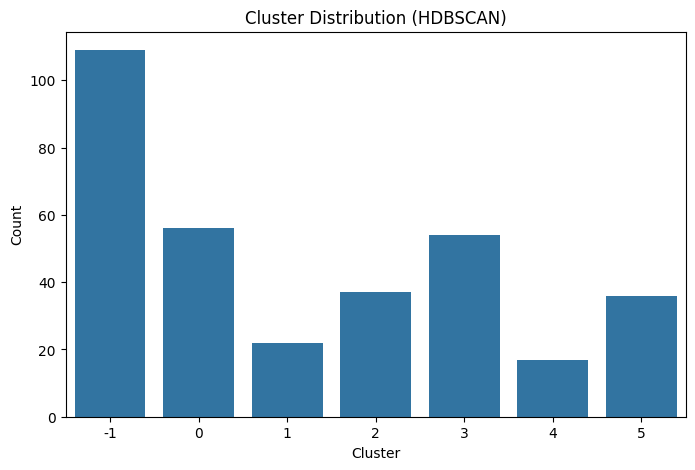

Silhouette Score: 0.4266
Davies–Bouldin Score: 0.8273
🔍 Top words for each cluster (for understanding):

📌 Cluster 0 - Top Words: bleeding, day, im, ive, like, month, pcod, pcos, period, year
                                         cleaned_text dominant_emotion  \
3   client reversed year old pcod year tired tryin...          neutral   
15  trapic mf working prolonged bleeding hi first ...         surprise   
16  urgent brown discharge instead period hi f sid...          neutral   

   sentiment_label  
3          Neutral  
15         Neutral  
16         Neutral  

📌 Cluster 1 - Top Words: day, dont, im, inositol, insulin, ive, like, pcos, period, taking
                                          cleaned_text dominant_emotion  \
90   inositol ive taking inositol week im taking pc...             fear   
95   inositol ive taking inositol year regular peri...         surprise   
106  myo dchiro inositol im start taking myo dchiro...         surprise   

    sentiment_label  
90          

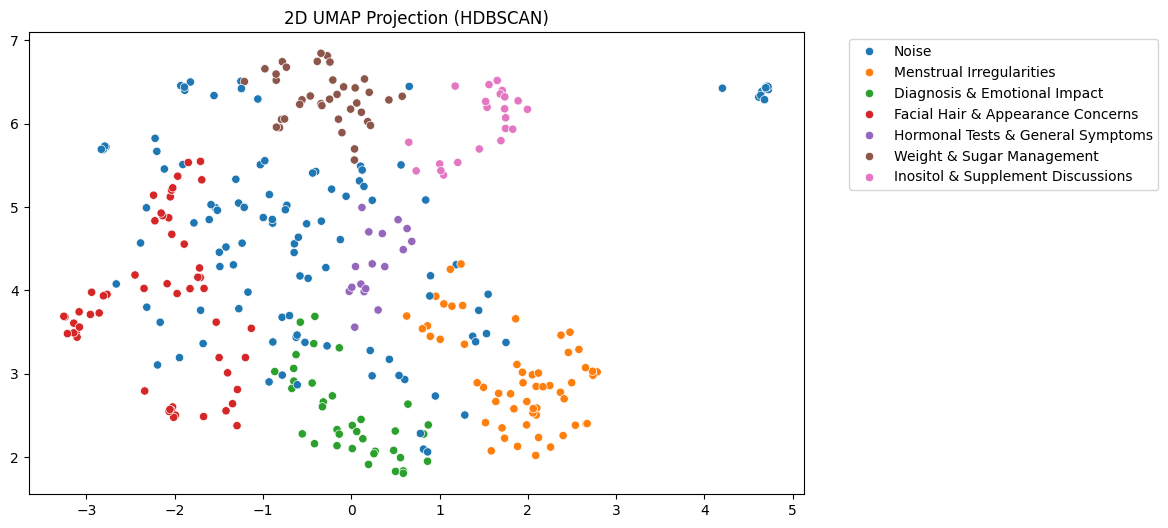

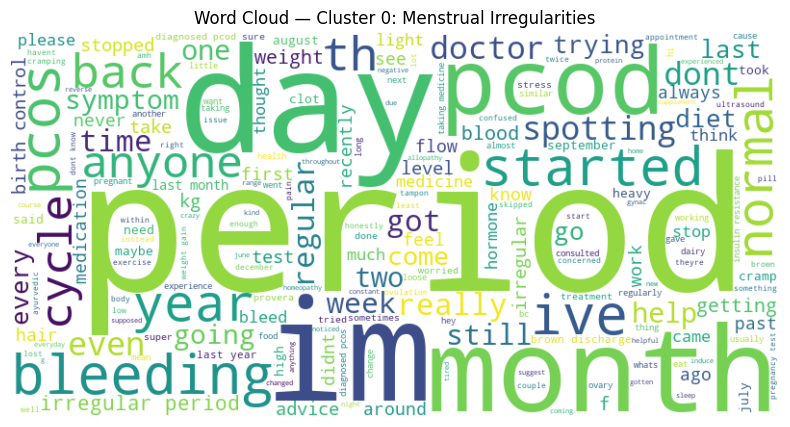

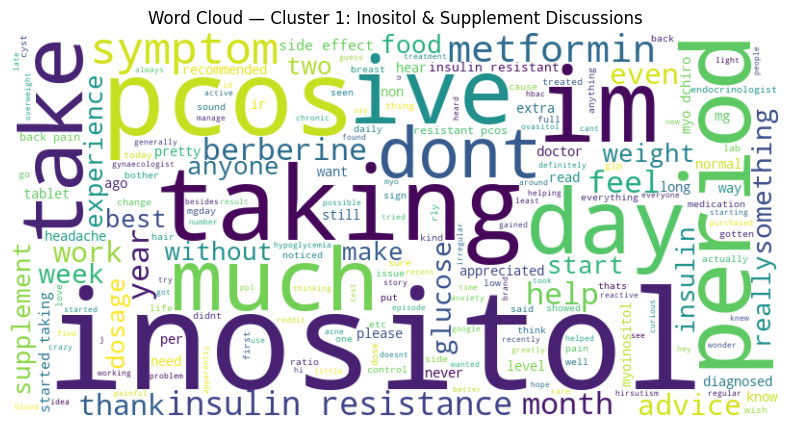

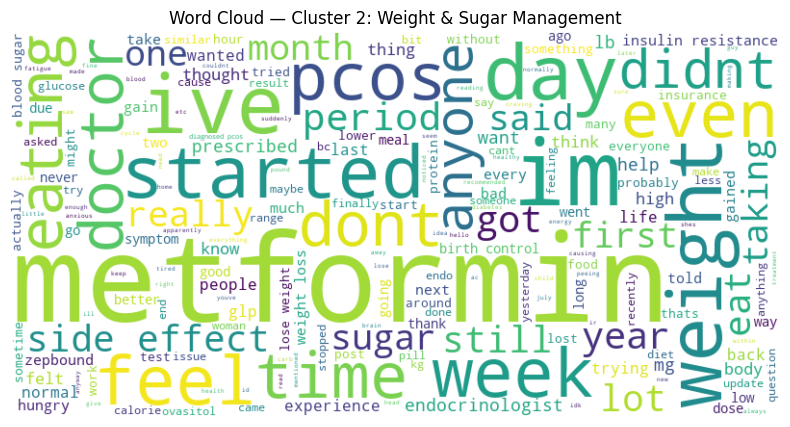

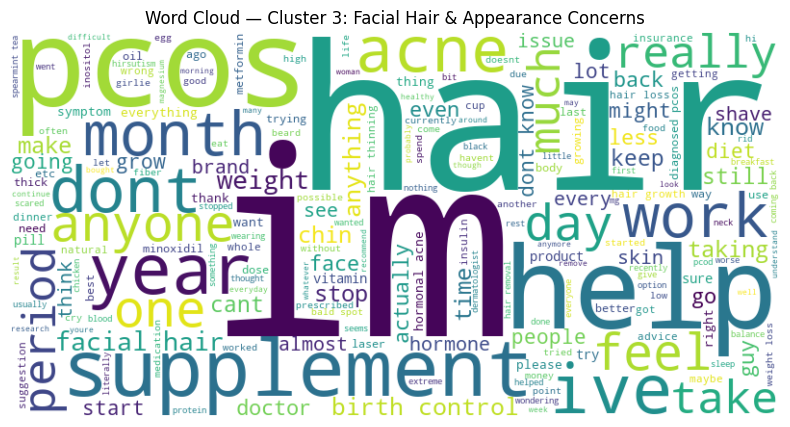

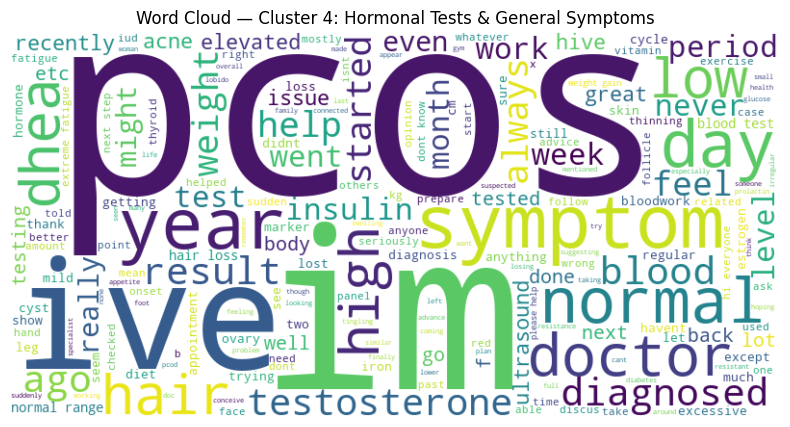

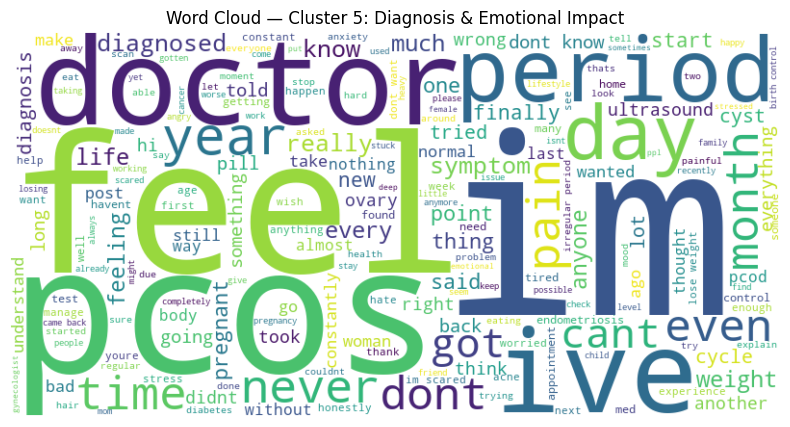

In [2]:
# ====================================================
# 1. Load Libraries
# ====================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer

# ====================================================
# 2. Load Data
# ====================================================
df = pd.read_csv("../data/pcod_sentiment_emotion.csv")
texts = df['cleaned_text'].dropna().tolist()

# ====================================================
# 3. Embeddings
# ====================================================
model = SentenceTransformer('BAAI/bge-base-en-v1.5')
embeddings = model.encode(texts, show_progress_bar=True)

# ====================================================
# 4. Dimensionality Reduction with UMAP
# ====================================================
umap_model = umap.UMAP(n_neighbors=10, n_components=10, random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# ====================================================
# 5. HDBSCAN Clustering
# ====================================================
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric='euclidean',
    cluster_selection_epsilon=0.05
)
df['cluster'] = clusterer.fit_predict(reduced_embeddings)

# ====================================================
# 6. Visualize Cluster Distribution
# ====================================================
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df)
plt.title("Cluster Distribution (HDBSCAN)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# ====================================================
# 7. Silhouette and DB Scores (excluding noise)
# ====================================================
valid = df['cluster'] != -1
if valid.sum() > 1:
    sil_score = silhouette_score(reduced_embeddings[valid], df.loc[valid, 'cluster'])
    db_score = davies_bouldin_score(reduced_embeddings[valid], df.loc[valid, 'cluster'])
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies–Bouldin Score: {db_score:.4f}")
else:
    print("⚠️ Not enough clustered samples to compute metrics")

# ====================================================
# 8. Print Top TF-IDF Words Per Cluster
# ====================================================
print("🔍 Top words for each cluster (for understanding):")
for i in sorted(df['cluster'].unique()):
    if i == -1:
        continue  # skip noise
    cluster_texts = df[df['cluster'] == i]['cleaned_text']
    tfidf = TfidfVectorizer(stop_words='english', max_features=10)
    tfidf_matrix = tfidf.fit_transform(cluster_texts)
    top_words = tfidf.get_feature_names_out()
    print(f"\n📌 Cluster {i} - Top Words: {', '.join(top_words)}")
    print(df[df['cluster'] == i][['cleaned_text', 'dominant_emotion', 'sentiment_label']].head(3))

# ====================================================
# 9. Optional: Assign Human-Readable Labels (update below)
# ====================================================
# List clusters and count
print("\n📊 Cluster Counts:\n", df['cluster'].value_counts())

# Example mapping – update after reviewing results
cluster_labels = {
    0: "Menstrual Irregularities",
    1: "Inositol & Supplement Discussions",
    2: "Weight & Sugar Management",
    3: "Facial Hair & Appearance Concerns",
    4: "Hormonal Tests & General Symptoms",
    5: "Diagnosis & Emotional Impact"
    # -1 is noise, not labeled
}
df['cluster_name'] = df['cluster'].map(cluster_labels).fillna("Noise")

# === Step 9: UMAP 2D Visualization ===
umap_2d = umap.UMAP(n_neighbors=10, n_components=2, random_state=42)
embedding_2d = umap_2d.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=df['cluster_name'], palette='tab10')
plt.title("2D UMAP Projection (HDBSCAN)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# === Step 10: Word Cloud per Cluster ===
for i in sorted(df['cluster'].unique()):
    if i == -1: continue
    cluster_text = " ".join(df[df['cluster'] == i]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud — Cluster {i}: {cluster_labels.get(i, "")}')
    plt.show()

In [3]:
df[['cleaned_text', 'cluster', 'cluster_name']].head(20)

,cleaned_text,cluster,cluster_name
0,help pcod routine please im f got diagnosed pc...,-1,Noise
1,pcod spotting jogging always wished body hiit ...,-1,Noise
2,building better tracking app focused right pro...,-1,Noise
3,client reversed year old pcod year tired tryin...,0,Menstrual Irregularities
4,possible get pregnant pcodpcos suffering pcod ...,5,Diagnosis & Emotional Impact
5,facial hair facing problem since last year ear...,3,Facial Hair & Appearance Concerns
6,help pcod journey would want hey girlies someo...,-1,Noise
7,weight gain hairfall emotional breakdown im ye...,5,Diagnosis & Emotional Impact
8,nari saundarya malt help year old girl facing ...,-1,Noise
9,got diagnosed pcod recently got diagnosed pcod...,-1,Noise


In [4]:
df.to_csv("../data/hdbscan_clustered.csv", index=False)